In [2]:
from config_figures import *
from scipy.stats import gaussian_kde
from math import floor, ceil

In [3]:
def get_area_lat_elev_df(drive_filename):
    df = pd.read_csv(google_drive_path + '/' + drive_filename + '.csv').drop(['system:index', '.geo'], axis=1)
    df = df[df['area_1981_2010'] != 0]
    df['area_1981_2010_1e6km2'] = df['area_1981_2010'] / 1e12
    return df[['species','area_1981_2010_1e6km2','latitude_1981_2010']]

def compute_area_lat_rolling_average(df, step, window):
    latitudes = np.arange(floor(df['latitude_1981_2010'].min()), ceil(df['latitude_1981_2010'].max()), step)
    median_area = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].median() for lat in latitudes]
    rolling_average_df = pd.DataFrame(data={'lat': latitudes, 'median_area': median_area}, index=None)
    rolling_average_df['rolling_average'] = rolling_average_df.median_area.rolling(window).mean()
    return rolling_average_df

def area_latitude_scatterplot(df, xlabel='SDM area (1e6 km2)', step=1, window=4, filename_to_save=None):
    x = df['area_1981_2010_1e6km2']
    y = df['latitude_1981_2010']
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig=plt.figure(figsize=(4,6))
    plt.scatter(x, y, c=z, s=1)
    plt.set_cmap('viridis')

    rolling_average_df = compute_area_lat_rolling_average(df, step, window)
    plt.plot(rolling_average_df['rolling_average'], rolling_average_df['lat'], 'r')

    plt.xlabel(xlabel)
    plt.ylabel('Median SDM latitude')
    if filename_to_save is not None : plt.savefig('../figures/' + filename_to_save)
    else: plt.show()

In [4]:
df_global = get_area_lat_elev_df(sdms_area_lat_elev_drive_filename)
df_global

,species,area_1981_2010_1e6km2,latitude_1981_2010
0,Abarema_barbouriana,0.941661,3.628973
1,Abarema_brachystachya,0.804058,-20.127242
2,Abarema_cochleata,0.579152,-2.438856
3,Abarema_filamentosa,0.303746,-12.438020
4,Abarema_jupunba,3.035330,2.124966
...,...,...,...
10585,Zygia_latifolia,4.536488,-0.876385
10586,Zygia_longifolia,1.311062,5.378190
10587,Zygia_racemosa,1.998093,0.374126
10588,Zygia_unifoliolata,2.838407,-0.874904


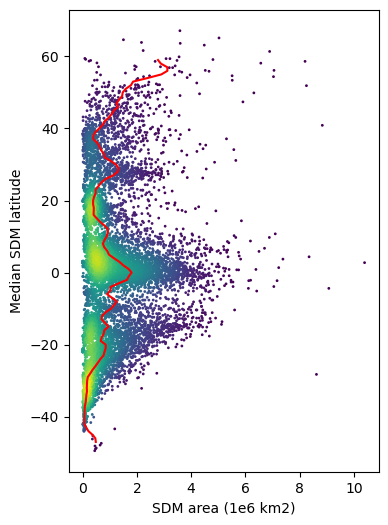

In [5]:
area_latitude_scatterplot(df_global)#filename_to_save='area_latitude_scatterplot_global.png')

In [6]:
df_forest = get_area_lat_elev_df(sdms_forest_area_lat_elev_drive_filename)
df_forest

,species,area_1981_2010_1e6km2,latitude_1981_2010
0,Abarema_barbouriana,0.919650,3.628381
1,Abarema_brachystachya,0.583012,-20.126729
2,Abarema_cochleata,0.511100,-2.438659
3,Abarema_filamentosa,0.212112,-12.685654
4,Abarema_jupunba,2.873850,2.124942
...,...,...,...
10585,Zygia_latifolia,4.073369,-0.629770
10586,Zygia_longifolia,1.218121,5.378197
10587,Zygia_racemosa,1.946435,0.374169
10588,Zygia_unifoliolata,2.536577,-1.126276


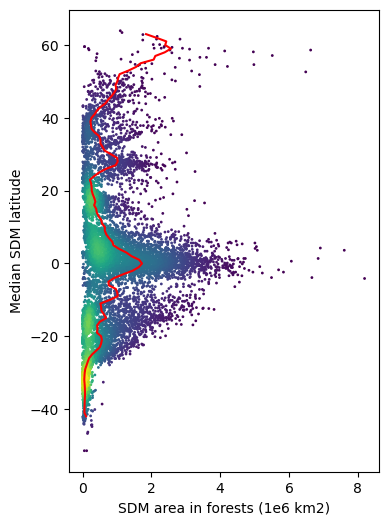

In [7]:
area_latitude_scatterplot(df_forest, xlabel='SDM area in forests (1e6 km2)')#, filename_to_save='area_latitude_scatterplot_forest.png')

In [8]:
df = df_global.merge(df_forest, on='species', suffixes=('_global', '_forest'))
df['area_decrease'] = (df['area_1981_2010_1e6km2_global'] - df['area_1981_2010_1e6km2_forest']) / df['area_1981_2010_1e6km2_global']
df

,species,area_1981_2010_1e6km2_global,latitude_1981_2010_global,area_1981_2010_1e6km2_forest,latitude_1981_2010_forest,area_decrease
0,Abarema_barbouriana,0.941661,3.628973,0.919650,3.628381,0.023375
1,Abarema_brachystachya,0.804058,-20.127242,0.583012,-20.126729,0.274914
2,Abarema_cochleata,0.579152,-2.438856,0.511100,-2.438659,0.117503
3,Abarema_filamentosa,0.303746,-12.438020,0.212112,-12.685654,0.301678
4,Abarema_jupunba,3.035330,2.124966,2.873850,2.124942,0.053200
...,...,...,...,...,...,...
10575,Zygia_latifolia,4.536488,-0.876385,4.073369,-0.629770,0.102088
10576,Zygia_longifolia,1.311062,5.378190,1.218121,5.378197,0.070890
10577,Zygia_racemosa,1.998093,0.374126,1.946435,0.374169,0.025854
10578,Zygia_unifoliolata,2.838407,-0.874904,2.536577,-1.126276,0.106338


In [9]:
df_realm = pd.read_csv(google_drive_path + '/' + sdm_realm_drive_filename + '.csv').drop(['system:index', '.geo'], axis=1)#.set_index('species')
df_realm = pd.melt(df_realm, id_vars=['species'], var_name = 'realm', value_name = 'sdm_frac')
df_realm = df_realm[df_realm['sdm_frac'] > 30]
df_realm

,species,realm,sdm_frac
35,Abrahamia_ditimena,Afrotropic,100
310,Acalypha_filiformis,Afrotropic,100
311,Acalypha_fruticosa,Afrotropic,86
312,Acalypha_glabrata,Afrotropic,100
316,Acalypha_neptunica,Afrotropic,100
...,...,...,...
95251,Zanthoxylum_armatum,Palearctic,58
95254,Zanthoxylum_bungeanum,Palearctic,86
95283,Zelkova_serrata,Palearctic,79
95290,Ziziphus_jujuba,Palearctic,63


In [10]:
tmp = df_realm.groupby('species').realm.count()
print(tmp[tmp < 1].shape) # number of species with no assigned realm
print(tmp[tmp == 1].shape) # number of species with exactly 1 assigned realm
print(tmp[tmp > 1].shape) # number of species with more than 1 assigned realm
print(tmp[tmp > 2].shape) # number of species with more than 2 assigned realms

(0,)
(10023,)
(567,)
(0,)


In [11]:
df_realm.groupby('realm')['species'].count() # number of species assigned to each realm -> not enough for oceania 

realm
Afrotropic     1495
Australasia    2194
Indomalayan    1079
Nearctic        759
Neotropic      4863
Oceania           6
Palearctic      761
Name: species, dtype: int64

In [12]:
df = df_realm.merge(df, 'left')
df

,species,realm,sdm_frac,area_1981_2010_1e6km2_global,latitude_1981_2010_global,area_1981_2010_1e6km2_forest,latitude_1981_2010_forest,area_decrease
0,Abrahamia_ditimena,Afrotropic,100,0.163680,-18.312670,0.152314,-18.188445,0.069442
1,Acalypha_filiformis,Afrotropic,100,0.231186,-18.312028,0.206419,-18.067083,0.107130
2,Acalypha_fruticosa,Afrotropic,86,2.739490,3.622603,1.316394,0.880937,0.519475
3,Acalypha_glabrata,Afrotropic,100,0.485851,-26.561575,0.284097,-27.311964,0.415259
4,Acalypha_neptunica,Afrotropic,100,1.455726,1.938744,1.313823,2.063839,0.097479
...,...,...,...,...,...,...,...,...
11152,Zanthoxylum_armatum,Palearctic,58,2.699242,28.436807,1.848082,27.812006,0.315333
11153,Zanthoxylum_bungeanum,Palearctic,86,2.458729,31.624484,1.380593,29.871997,0.438493
11154,Zelkova_serrata,Palearctic,79,0.543903,35.312620,0.459556,35.063632,0.155078
11155,Ziziphus_jujuba,Palearctic,63,5.643786,31.125189,2.526199,28.624853,0.552393


In [31]:
df_by_realm = df.groupby('realm')['area_1981_2010_1e6km2_global'].agg(['median','count']).rename(columns={'median':'median_area', 'count': 'n_species'}).sort_values('median_area')
df_by_realm['n_species_10'] = df[df['area_decrease'] > 0.1].groupby('realm')['species'].count()
df_by_realm['n_species_25'] = df[df['area_decrease'] > 0.25].groupby('realm')['species'].count()
df_by_realm['n_species_50'] = df[df['area_decrease'] > 0.5].groupby('realm')['species'].count()
df_by_realm['n_species_99'] = df[df['area_decrease'] > 0.99].groupby('realm')['species'].count()
df_by_realm['frac_species_10'] = df_by_realm['n_species_10'] / df_by_realm['n_species'] * 100
df_by_realm['frac_species_25'] = df_by_realm['n_species_25'] / df_by_realm['n_species'] * 100
df_by_realm['frac_species_50'] = df_by_realm['n_species_50'] / df_by_realm['n_species'] * 100
df_by_realm['frac_species_99'] = df_by_realm['n_species_99'] / df_by_realm['n_species'] * 100
df_by_realm

,median_area,n_species,n_species_10,n_species_25,n_species_50,n_species_99,frac_species_10,frac_species_25,frac_species_50,frac_species_99
realm,,,,,,,,,,
Oceania,0.005920,6,5,3,2,NaN,83.333333,50.000000,33.333333,NaN
Australasia,0.212340,2186,1854,1308,857,131.0,84.812443,59.835316,39.204026,5.992681
Nearctic,0.605595,759,626,454,263,17.0,82.476943,59.815547,34.650856,2.239789
Afrotropic,0.949428,1495,713,493,191,4.0,47.692308,32.976589,12.775920,0.267559
Indomalayan,1.034628,1079,727,387,26,NaN,67.377201,35.866543,2.409639,NaN
Neotropic,1.050443,4863,2946,1656,149,1.0,60.579889,34.053054,3.063952,0.020563
Palearctic,1.250677,759,737,499,120,1.0,97.101449,65.744401,15.810277,0.131752


In [32]:
df_by_realm = df_by_realm.drop('Oceania').fillna(0)
df_by_realm

,median_area,n_species,n_species_10,n_species_25,n_species_50,n_species_99,frac_species_10,frac_species_25,frac_species_50,frac_species_99
realm,,,,,,,,,,
Australasia,0.212340,2186,1854,1308,857,131.0,84.812443,59.835316,39.204026,5.992681
Nearctic,0.605595,759,626,454,263,17.0,82.476943,59.815547,34.650856,2.239789
Afrotropic,0.949428,1495,713,493,191,4.0,47.692308,32.976589,12.775920,0.267559
Indomalayan,1.034628,1079,727,387,26,0.0,67.377201,35.866543,2.409639,0.000000
Neotropic,1.050443,4863,2946,1656,149,1.0,60.579889,34.053054,3.063952,0.020563
Palearctic,1.250677,759,737,499,120,1.0,97.101449,65.744401,15.810277,0.131752


Australasia 0.39061075660893346
Nearctic 0.3465085638998682
Afrotropic 0.1277591973244147
Indomalayan 0.024096385542168676
Neotropic 0.0306395229282336
Palearctic 0.15768725361366623


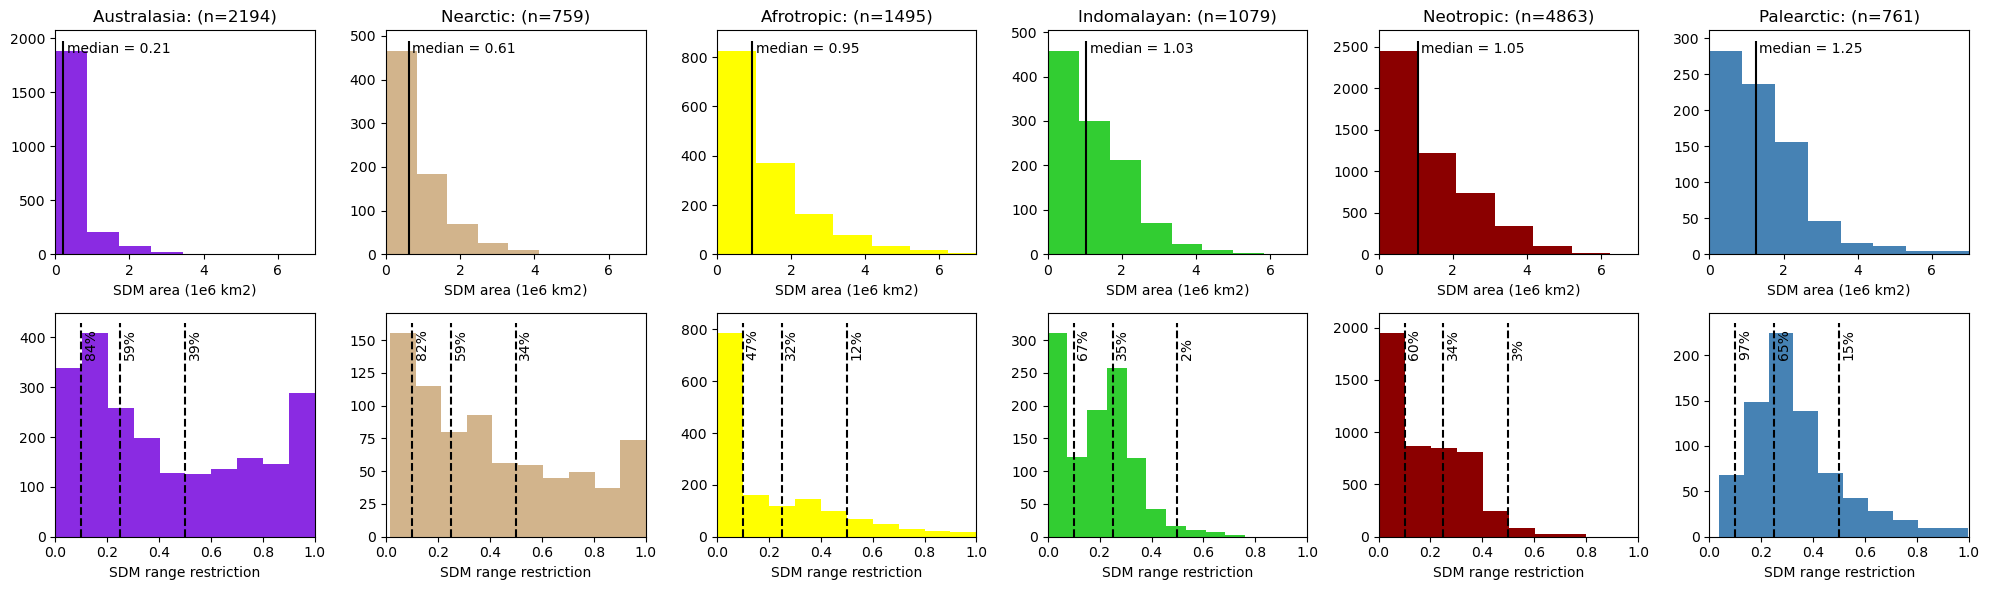

In [40]:
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20,6))#, sharex='row')
variables = ['area_1981_2010_1e6km2_global', 'area_decrease']
realms = df_by_realm.index.tolist()
colors = ['blueviolet', 'tan', 'yellow', 'limegreen', 'darkred', 'steelblue']

for ax_row, v in zip(axs, variables):
    for ax, realm, c in zip(ax_row, realms, colors):
        df_var = df[df['realm'] == realm][v]
        ax.hist(df_var, bins=10, color=c)
        n = df_var.shape[0]
        
        if v == 'area_1981_2010_1e6km2_global':
            # ax.hist(df_realm[v], bins=10, range=(0,7), color=c)
            ax.set_xlim(0,7)
            ax.set_title(f"{realm}: (n={n})")
            ax.set_xlabel('SDM area (1e6 km2)')

            median_area = df_by_realm.loc[realm, 'median_area']
            ax.vlines(median_area, 0, ax.get_ylim()[1], colors='k')
            ax.text(median_area+0.1, ax.get_ylim()[1]*0.9, f"median = {median_area:.2f}")#, rotation=90)

        elif v == 'area_decrease':
            # ax.hist(df_realm[v], bins=10, range=(0,1), color=c)
            ax.set_xlim(0,1)
            ax.set_xlabel('SDM range restriction') 
                  
            ax.vlines([0.1, 0.25, 0.5], 0, ax.get_ylim()[1], colors='k', linestyles='dashed')
            ax.text(0.11, ax.get_ylim()[1] * 0.8, f"{int(df_by_realm.loc[realm, 'frac_species_10'])}%", rotation = 90) 
            ax.text(0.26, ax.get_ylim()[1] * 0.8, f"{int(df_by_realm.loc[realm, 'frac_species_25'])}%", rotation = 90) 
            ax.text(0.51, ax.get_ylim()[1] * 0.8, f"{int(df_by_realm.loc[realm, 'frac_species_50'])}%", rotation = 90) 
            # ax.text(0.93, ax.get_ylim()[1] * 0.8, f"{int(df_by_realm.loc[realm, 'frac_species_99'])}%", rotation = 90) 

            print(realm, df_var[df_var >= 0.5].shape[0] / n)
        
        #ax.set_ylabel('Number of species')


plt.tight_layout()


In [27]:
df_by_realm

,median_area,n_species,n_species_10,n_species_25,n_species_50,n_species_90,frac_species_10,frac_species_25,frac_species_50,frac_species_90
realm,,,,,,,,,,
Australasia,0.212340,2186,1854,1308,857,289.0,84.812443,59.835316,39.204026,13.220494
Nearctic,0.605595,759,626,454,263,74.0,82.476943,59.815547,34.650856,9.749671
Afrotropic,0.949428,1495,713,493,191,20.0,47.692308,32.976589,12.775920,1.337793
Indomalayan,1.034628,1079,727,387,26,0.0,67.377201,35.866543,2.409639,0.000000
Neotropic,1.050443,4863,2946,1656,149,2.0,60.579889,34.053054,3.063952,0.041127
Palearctic,1.250677,759,737,499,120,10.0,97.101449,65.744401,15.810277,1.317523


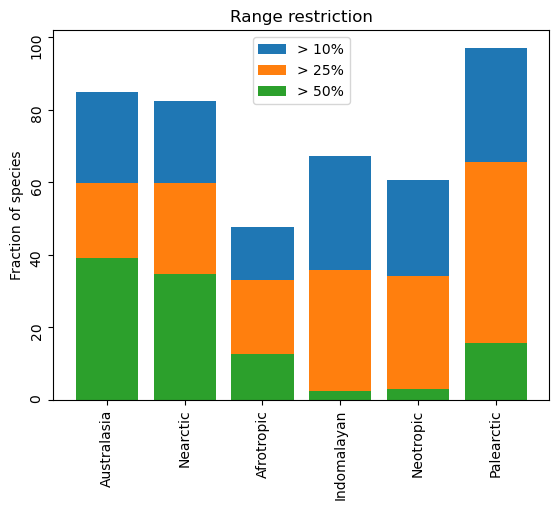

In [28]:
fig, ax = plt.subplots()

ax.bar(df_by_realm.index, df_by_realm.frac_species_10, label='> 10%')
ax.bar(df_by_realm.index, df_by_realm.frac_species_25, label= '> 25%')
ax.bar(df_by_realm.index, df_by_realm.frac_species_50, label='> 50%')

ax.set_ylabel('Fraction of species')
ax.tick_params(labelrotation=90)
ax.set_title('Range restriction')
ax.legend()

plt.show()

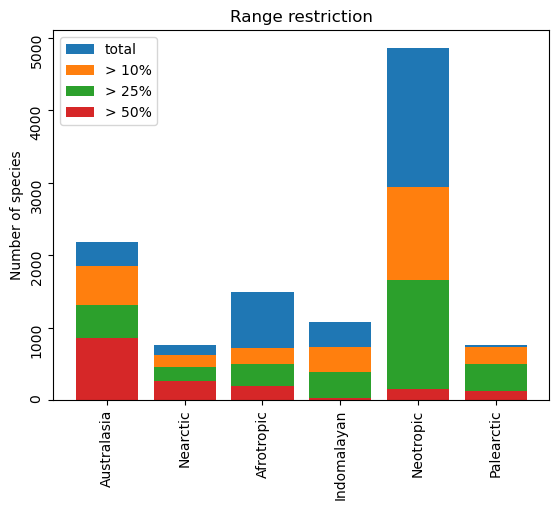

In [330]:
fig, ax = plt.subplots()

ax.bar(df_by_realm.index, df_by_realm.n_species, label = 'total')
ax.bar(df_by_realm.index, df_by_realm.n_species_10, label= '> 10%')
ax.bar(df_by_realm.index, df_by_realm.n_species_25, label= '> 25%')
ax.bar(df_by_realm.index, df_by_realm.n_species_50, label='> 50%')

ax.set_ylabel('Number of species')
ax.tick_params(labelrotation=90)
ax.set_title('Range restriction')
ax.legend()

plt.show()